# Exploring Ectomycorrhizal Diversity in NEON Data
Ectomycorrhizal fungi form important relationships with plants to exchange nutrients vital to both parties survival and growth. Their association is intimate and we are trying to figure out how to understand and protect the conditions which enable their interaction. From 2014 to 2019 soil samples were collected from across the National Ecological Observation Network. These soil samples were paired with measured and calculated climate data. Soil samples were DNA sequenced and the presence of a collection of ectomycorrhizal fungi was determined. This data investigation looks to find quantitative relationships between fungal diversity and climate variables. 

### Importing Libraries and Configuring Notebook
This section brings in libraries for the analysis.

In [2]:
import pandas as pd
import numpy as np 
import geopandas as gpd 
import seaborn as sns
import matplotlib.pyplot as plt 
import scipy.stats
import hvplot.pandas
import holoviews as hv

import warnings
warnings.filterwarnings("ignore")

## Reading in the Data 
Three datasets were provided. The data lives in the `data` directory within the repository. 

1. **NEON Domains (.shp)**:
The NEON Domains shapefile contains polygons of the biogeographic domains delineated by NEON. These polygons were created through an extensive process to ensure that they differentiate areas of distinct biogeographic characteristics. This file is read in as a geopandas GeoDataFrame to preserve the polygons' geometries. 

2. **NEON Metadata (.csv)**:
The NEON metadata file contains data from the soil samples as well as the measured and calculated climate variables. This data is intersected with the NEON domains to determine which biogeographic domain contains the sampling site.

3. **NEON Species Table (.csv)**: 
This dataset contains DNA sequencing information from each of the soil samples. Columns represent EcM species. This table is used to calculate relative abundance for species.


In [3]:
#Data lives in "data" directory

#Read in NEON Domain Shapefile
neon_domains_gdf = gpd.read_file("../data/NEONDomains_0/NEON_Domains.shp")

#Read in NEON metadata
metadata = pd.read_csv("../data/NEON_metadata.csv")

#Spatialize NEON metadata
metadata_geom = gpd.GeoSeries.from_xy(metadata['longitude'], metadata['latitude'])
metadata_gdf = gpd.GeoDataFrame(metadata, geometry=metadata_geom) 
metadata['domain'] = gpd.sjoin(metadata_gdf, neon_domains_gdf, how="inner", op="within")['DomainName']

#Extract site IDs and merge datetime data into a collectDate
metadata['site'] = metadata['plotID'].apply(lambda s: s[:4])
metadata['collectDate'] = pd.to_datetime(metadata['collectYear'] * 1000 + metadata['collectDOY'], format="%Y%j")

#Keep track of metadata column names
metadata_columns = metadata.columns

#Read in EcM observations
ecm_observations = pd.read_csv("../data/NEON_species_table.csv")
#Keep track of species names
species_columns = ecm_observations.columns[3:]

## Relating Datasets
The species observation and metadata datasets can be joined together and any repeated columns can be dropped.

In [4]:
#Merging Metadata and EcM observations
clim_ecm_abundance = metadata.merge(ecm_observations.drop(columns = ["plotID", "collectYear", "collectDOY"]), how="inner", left_index=True, right_index=True)

In [5]:
#Calculate Shannon Diversity from relative abundances
#Calculate Relative Abundance
clim_ecm_abundance['count_observations'] = clim_ecm_abundance[species_columns].sum(axis=1)

#Assert no zero counts are present
assert not any(clim_ecm_abundance['count_observations'] == 0)

#Calculate relative abundances
clim_ecm_abundance[species_columns] = clim_ecm_abundance[species_columns].div(clim_ecm_abundance['count_observations'], axis=0)

#Climate Variables and Alpha Diversity Index (Shannon Diversity)
clim_sdi = clim_ecm_abundance[metadata_columns]
clim_sdi['shannon_diversity'] = -(clim_ecm_abundance[species_columns] * np.log(clim_ecm_abundance[species_columns], where=clim_ecm_abundance[species_columns] != 0)).sum(axis=1)

#Save this dataset for future analysis
clim_sdi.to_csv("../data/climate_sdi.csv")
clim_ecm_abundance.to_csv("../data/climate_ecm_abundance.csv")

## Cleaning the Data
Taking a quick look at the data reveals that there are a few things to clean up. The first is that there are some missing soil pH and soil moisture values. Soil pH and soil moisture values tend to concentrate around a mean for each site. So for each nan, lookup the site's mean soil pH or moisture and fill it in.

In [6]:
clim_sdi['soil_pH'] = clim_sdi['soil_pH'].fillna(clim_sdi.groupby('site')['soil_pH'].transform('mean'))
clim_sdi['soil_moisture'] = clim_sdi['soil_moisture'].fillna(clim_sdi.groupby('site')['soil_moisture'].transform('mean'))

## Calculating the Shannon Diversity Index
The species observation and metadata datasets can be joined together and any repeated columns can be dropped.

**Adding Shannon Diversity**
Fungal diversity in the metadata dataset is calculated as the number of unique species present within a sample. While this does provide an indication of species richness in the sample, it doesn't indicate evennness which is an important characteristic of EcM communities to investigate. Additionally, when looking at the distribution of fungal diversity values, we see a left-skewed distribution. While the skew can be accounted for, we see a more balanced distribution of Shannon Diversity.

One-way ANOVA performed on fungal diversity values from each domain: F_onewayResult(statistic=165.3839278998084, pvalue=0.0)
One-way ANOVA performed on Shannon diversity values from each domain: F_onewayResult(statistic=52.10508159274605, pvalue=4.761448531001311e-174)


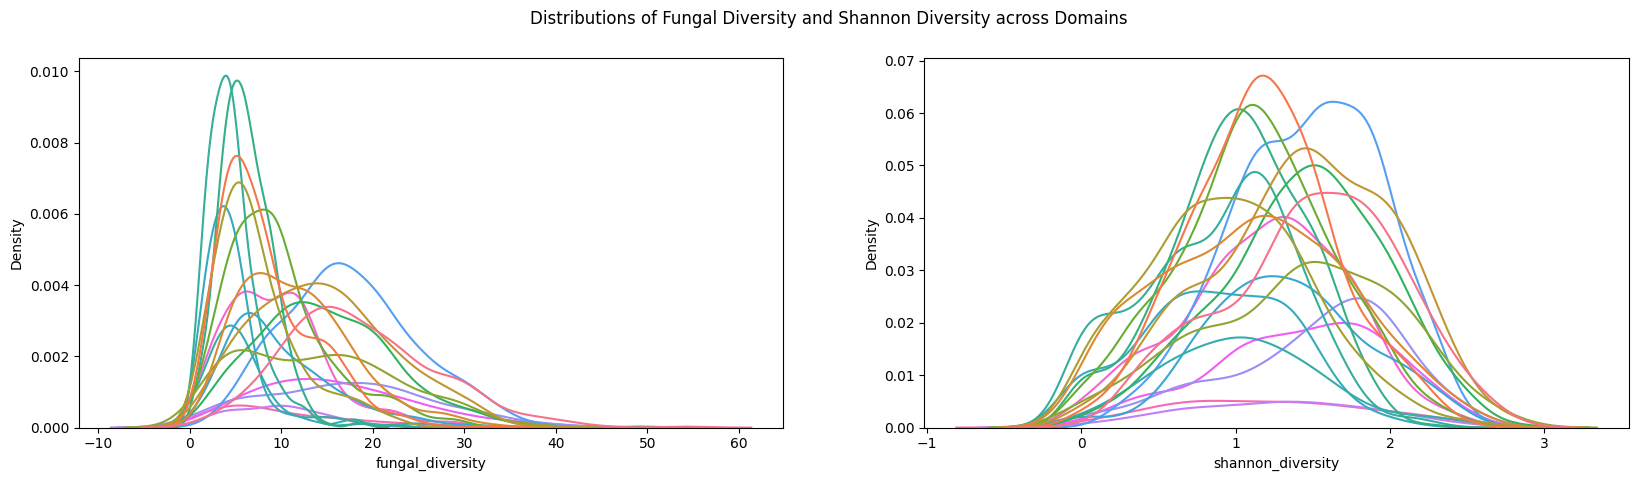

In [7]:
#Plot the distributions of fungal diversity and Shannon Diversity
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)
fig.suptitle("Distributions of Fungal Diversity and Shannon Diversity across Domains")
g1 = sns.kdeplot(clim_sdi, x="fungal_diversity", ax=ax[0], hue="domain");
ax[0].legend([], [], frameon=False)
g2 = sns.kdeplot(clim_sdi, x="shannon_diversity", ax=ax[1], hue="domain");
ax[1].legend([], [], frameon=False)

#Performing ANOVA one way helps to understand differences in diversity distributions for each metric across the domains
fungal_diversity_anova = scipy.stats.f_oneway(*[domain.values for name, domain in clim_sdi.groupby('domain')['fungal_diversity']])
shannon_diversity_anova = scipy.stats.f_oneway(*[domain.values for name, domain in clim_sdi.groupby('domain')['shannon_diversity']])

print(f"One-way ANOVA performed on fungal diversity values from each domain: {fungal_diversity_anova}")
print(f"One-way ANOVA performed on Shannon diversity values from each domain: {shannon_diversity_anova}")

## Balancing the Sample Sizes across Sites
The variables `precip_mm`, `precip_seasonality`, `temp_celsius`, and `temp_seasonality` are all calculated at the site level and remain static. Because some sites appear more than others in the dataset on account of being surveyed a greater number of times, the representation of each of these variables in the analysis differ. To understand how much of an effect these imbalanced sets of values play on our analysis, we can conduct Kolmogorov-Smirnov test to see if the distribution of our target variable `shannon_diversity` is significantly different in the balanced and original set. After the test is run, we see that we fail to reject the null-hypothesis (that the two distributions are drawn from the same underlying population) with a `threshold = 0.05` and the random sampling was effective in preserving the underlying distribution of the data. 

To create the balanced dataset, I locate the site with the least number of samples `(nmin=10)` and randomly sample `nmin` points from the other sites. We sample by site and not domain because we are more concerned with creating equally sized sets for each unique combination of climate variables.

In [8]:
balanced_clim_sdi = clim_sdi.groupby("site").sample(n=10, random_state=9)

In [9]:
# Performing the Kolmogorov-Smirnov test
ks_statistic, p_value = scipy.stats.ks_2samp(clim_sdi['shannon_diversity'], balanced_clim_sdi['shannon_diversity'])

print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

KS Statistic: 0.06030408979255195
P-value: 0.09055547074233095


### Transforming Skewed Soil Moisture
Looking closer at the climate variables present in the dataset, soil moisture stands out as a strongly skewed distribution. To normalize the distribution, the soil moisture data is transformed using a log transformation.

In [10]:
balanced_clim_sdi['log_soil_moisture'] = np.log(balanced_clim_sdi['soil_moisture'])

## Understanding Relatedness of Climate Variables and EcM Diversity
Now that we know a little more about the distribution of EcM diversity across domains and have accounted for sample size bias in the dataset, we can look into quantifying the relationship between climate variables and diversity. The correlation plot below shows the Spearman Correlation test rho for each pair of variables. Each plot in the lower triangle also shows a linear regression fit to the data. For Shannon Diversity, `precip_mm` is shown to have the strongest correlation.

<Figure size 1500x1500 with 0 Axes>

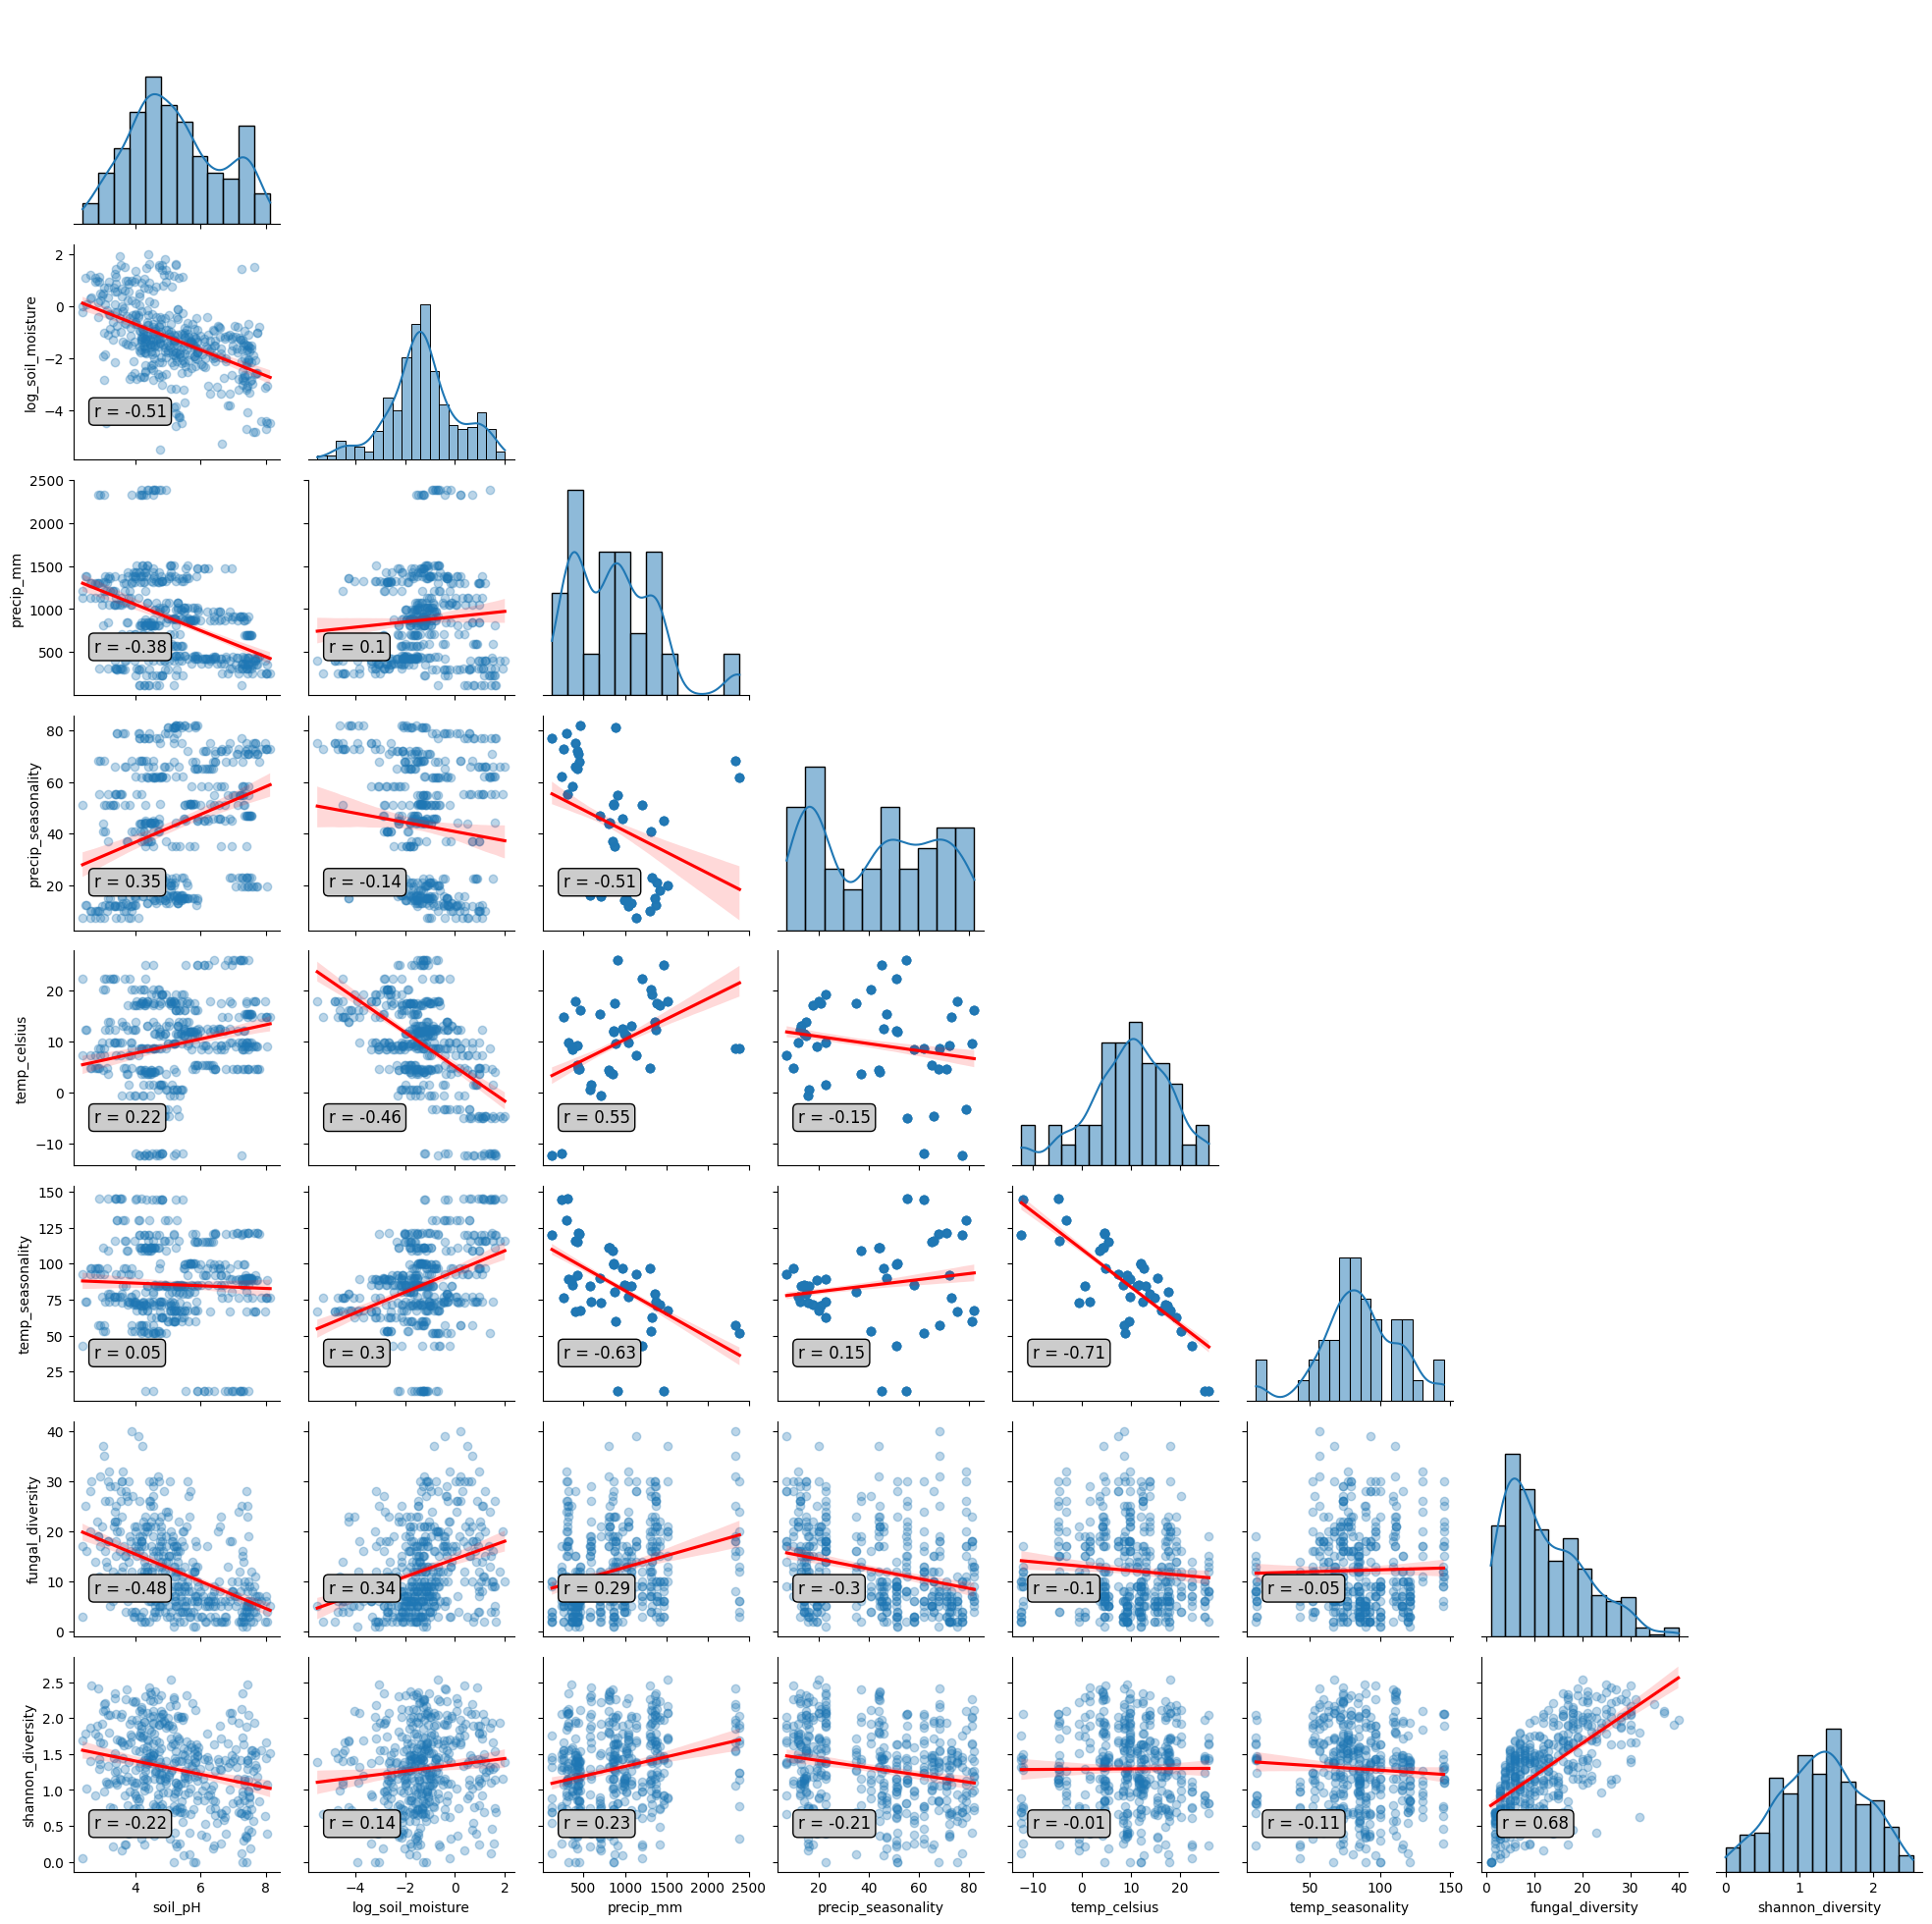

In [11]:
corr_df = balanced_clim_sdi[['soil_pH', 'log_soil_moisture', 'precip_mm', 'precip_seasonality', 'temp_celsius','temp_seasonality', 'fungal_diversity', 'shannon_diversity']]

def PlotCorrelationCoefficient(x, y, **kwargs):
    r, p = scipy.stats.spearmanr(x, y)
    sns.regplot(x=x, y=y, line_kws = {"color": "red"}, scatter_kws={"alpha":0.3})
    ax = plt.gca()
    ax.annotate(f'r = {r.round(2)}', (0.1, 0.2), xycoords=ax.transAxes, bbox={"boxstyle":"round", "fc":"0.8"}, size=12)

plt.figure(figsize=(15,15))
corrplot = sns.PairGrid(corr_df, corner=True)
corrplot.map_diag(sns.histplot, kde=True)
corrplot.map_lower(PlotCorrelationCoefficient);

## Investigating Annual Precipitation
Seeing the positive correlation between mean annual cumulative precipitation and Shannon Diversity made me curious. I began wondering how might the average Shannon Diversity of each domain change under extreme precipitation scenarios. To further investigate, I estimated extreme precipitation values for each domain and used the linear regression to predict the mean EcM Shannon Diversity. 

I continued under a set of assumptions: 

- The distribution of daily precipitation values for each domain are approximated by a gaussian distribution. 
- The linear regression estimated the relationship between precipitation and EcM diversity although the relationship was shown to be non-parametric.

With more time, I would be keen to build more informed daily precipitation distributions. 

## Calculating an Extreme Annual Precipitation Case
For each domain, I estimated a mean daily precipitation and the standard deviation of daily precipitation. I then calculated a 95th percentile cumulative annual precipitation from those parameters and estimated Shannon Diversity from the linear regression trained on samples from all domains.

In [12]:
precip_95pct_domain = {}
#Estimate standard deviation and mean of daily precipitation values
for domain, domain_data in balanced_clim_sdi.groupby("domain"):
    est_mean_daily_precip = np.mean(domain_data['precip_mm'])/365
    est_daily_precip_stdev = est_mean_daily_precip * np.mean(domain_data['precip_seasonality'] /100)
    
    precip_95pct_domain[domain] = {}
    
    #Estimate 95th Percentile Annual Precip, assuming a Gaussian distribution
    precip_95pct_domain[domain]['95pct_annual_precip'] = (est_mean_daily_precip + (est_daily_precip_stdev * 2)) * 365
    
#Get relationship between precipitation and shannon diversity
precip_sdi_linreg = scipy.stats.linregress(balanced_clim_sdi['precip_mm'], balanced_clim_sdi['shannon_diversity'])
slope, intercept, r_value, p_value, std_err = precip_sdi_linreg

#Calculate predicted change in shannon diversity for each domain
for domain, domain_extreme_stats in precip_95pct_domain.items():
    predict_sdi = slope * domain_extreme_stats['95pct_annual_precip'] + intercept
    mean_obs_sdi = np.mean(balanced_clim_sdi.loc[balanced_clim_sdi['domain'] == domain]['shannon_diversity'])
    
    precip_95pct_domain[domain]['Predicted Shannon Diversity'] = predict_sdi
    precip_95pct_domain[domain]['Obs. Shannon Diversity'] = mean_obs_sdi

precip_95pct_domain_df = pd.DataFrame.from_dict(precip_95pct_domain).T
precip_95pct_domain_df.index = precip_95pct_domain_df.index.rename("Domain")


## Visualizing SDI Change Under Extreme Annual Precip. by Domain
The visualization below shows the predicted mean Shannon Diversity under the 95th percentile precipitation scenario against the observed mean in the provided samples. While most of the domains are predicted to gain EcM diversity, a few are predicted to decrease in mean SDI.

In [13]:
scatterplot = precip_95pct_domain_df.hvplot.scatter(x="Obs. Shannon Diversity", y="Predicted Shannon Diversity", by="Domain", legend=False, s=100, cmap="tab20")
lineplot = hv.Curve((np.arange(0.0, 3.0, 0.01), np.arange(0.0, 3.0, 0.01)), 'x', 'y')
overlayplot = scatterplot * lineplot

overlayplot = overlayplot * hv.Text(x=1.25, y=2.25, text='Shannon Diversity Gain')
overlayplot = overlayplot * hv.Text(x=2.1, y=1.1, text='Shannon Diversity Loss')
overlayplot = overlayplot * hv.Text(x=2.2, y=1.9, text='No Change Line')
overlayplot = overlayplot * hv.Text(x=0.85, y=2.55, text='[Interactive]')

overlayplot = overlayplot.redim.range(x=(0.7, 2.6), y=(0.7, 2.6))
overlayplot = overlayplot.opts(
    width=800, 
    height=800, 
    toolbar=None, 
    xlabel="Mean Obs. Shannon Diversity", 
    ylabel="Predicted Mean Shannon Diversity", 
    title="Predicted Mean Shannon Diversity under 95th pct Annual Precipitation across Domains",
    fontsize={'title':13, 'labels':14, 'xticks':10, 'yticks':10},
    active_tools=[]
    )

hvplot.save(overlayplot, '../figures/95pctPrecipSDIDomain.html')

overlayplot

:Overlay
   .NdOverlay.I :NdOverlay   [Domain]
      :Scatter   [Obs. Shannon Diversity]   (Predicted Shannon Diversity)
   .Curve.I     :Curve   [x]   (y)
   .Text.I      :Text   [x,y]
   .Text.II     :Text   [x,y]
   .Text.III    :Text   [x,y]
   .Text.IV     :Text   [x,y]